Loaded A: 7061945 pts | attrs: ['colors']
Loaded B: 10448025 pts | attrs: ['intensity']
Pick polygon on Cloud A - USING MANUAL CORNERS (xyz):
  C0: [5.7394, 11.3981, 3.6963]
  C1: [6.1136, 9.7939, -26.9640]
  C2: [6.7788, -2.9505, -26.0620]
  C3: [5.7676, -0.8603, 3.2157]
Pick polygon on Cloud B - USING MANUAL CORNERS (xyz):
  C0: [0.9628, 0.3106, -0.7714]
  C1: [1.0467, -13.6025, -3.1459]
  C2: [3.5010, -14.9324, 28.4675]
  C3: [3.3286, -2.2168, 29.2512]
Segmented A: 2931328 pts; B: 3632420 pts
Flattened both segments to shared ground (Z-up, plane z=0).

USING MANUAL CORRESPONDENCES (FLAT frames):
  P0: A[-3.7898, 11.2035, -0.1126]  ↔  B[-2.2170, -12.9798, 0.6541]
  P1: A[26.7967, 10.0796, -0.0130]  ↔  B[27.8388, -14.1173, -0.1863]
  P2: A[26.1484, -2.5826, 0.4296]  ↔  B[28.4184, -2.1563, -0.2134]
  P3: A[-3.1512, -1.0254, -0.2649]  ↔  B[-0.6464, -1.0098, 0.8785]
Saved: A_aligned_flat.ply and B_flat.ply (shared ground, A aligned onto B).


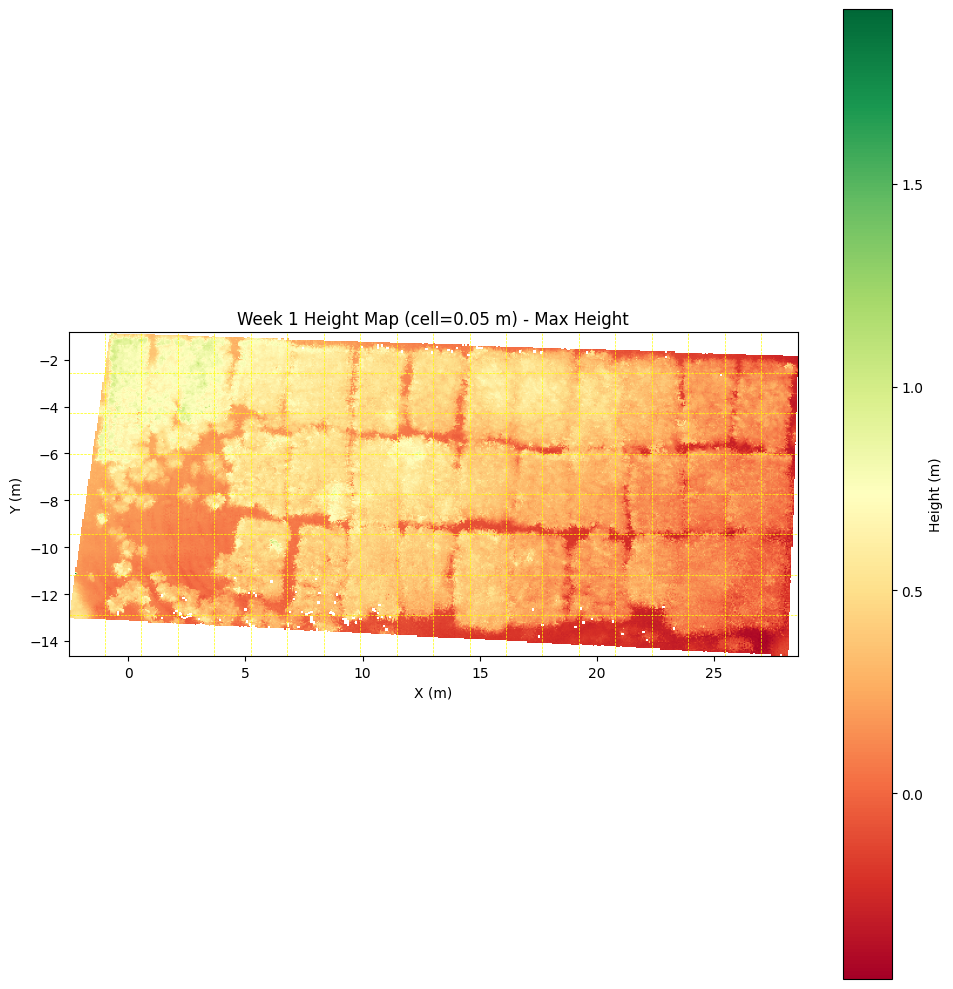

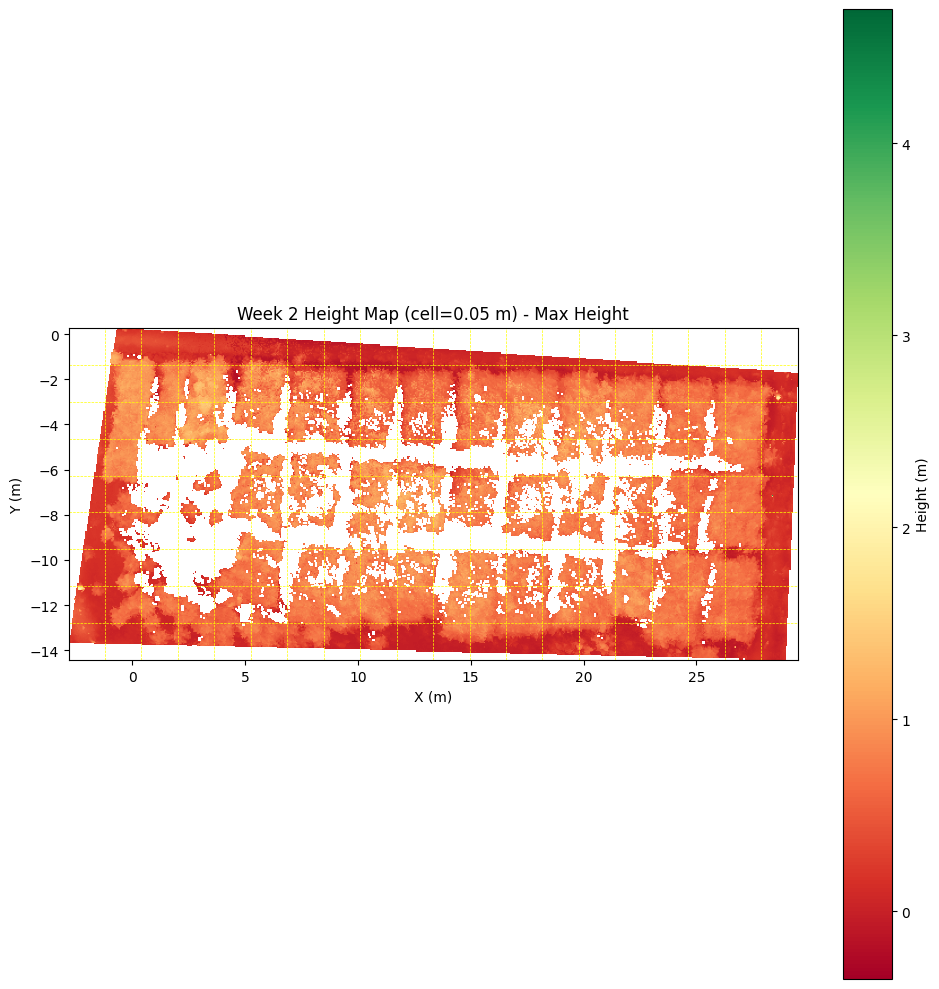

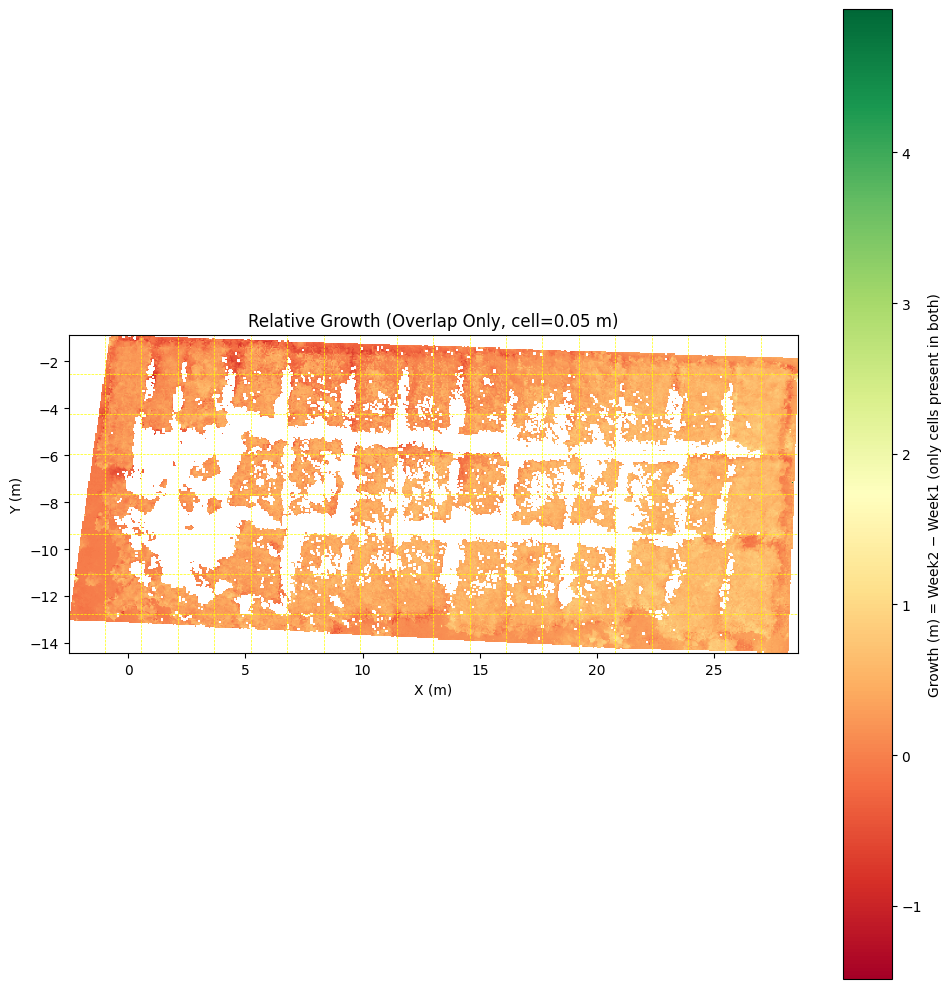


Done. Outputs in: C:\Users\musab\OneDrive - Higher Education Commission\LUMS\Robotics\Summer 2025\Crop Growth\LUMS Field Scans 2025\28-08-2025\alignment_outputs
 - A_segmented.ply / B_segmented.ply (with RGB or intensity if available)
 - A_aligned_flat.ply / B_flat.ply (shared ground, preserved attributes)
 - week1_height_map.png / week2_height_map.png / relative_growth_map.png


In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# ==========================
# User parameters
# ==========================
INPUT_PCD_A = "../19-08-2025/08_19_23_23.pcd"          # Week 1 (reference)
INPUT_PCD_B = "08_28_36_47.pcd"          # Week 2 (to be aligned)

OUTPUT_DIR = Path("alignment_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Segmentation controls ---
# If set to 4x3 lists, the script SKIPS polygon picking and uses these directly.
# Cloud A (manual corners, raw xyz)
MANUAL_CORNERS_A = [
    [5.7394, 11.3981,  3.6963],
    [6.1136,  9.7939, -26.9640],
    [6.7788, -2.9505, -26.0620],
    [5.7676, -0.8603,  3.2157],
]

# Cloud B (picked interactively, raw xyz)
MANUAL_CORNERS_B = [
    [0.9628,   0.3106,  -0.7714],
    [1.0467, -13.6025,  -3.1459],
    [3.5010, -14.9324,  28.4675],
    [3.3286,  -2.2168,  29.2512],
]


# Which 2D plane to project onto for polygon selection: 'XY', 'YZ', or 'XZ'
SELECTION_PLANE = "YZ"  # change to 'XY' if your clouds are Z-up

# --- Correspondence controls ---
# If both arrays are provided and have the same length >= 4, the script SKIPS interactive picking.
# Each is an Nx3 list of xyz coordinates in the FLATTENED frames (after shared-ground flattening).
MANUAL_CORR_A = [
    [-3.7898, 11.2035, -0.1126],  # P0
    [26.7967, 10.0796, -0.0130],  # P1
    [26.1484, -2.5826,  0.4296],  # P2
    [-3.1512, -1.0254, -0.2649],  # P3
]

MANUAL_CORR_B = [
    [-2.2170, -12.9798,  0.6541], # R0
    [27.8388, -14.1173, -0.1863], # R1
    [28.4184,  -2.1563, -0.2134], # R2
    [-0.6464,  -1.0098,  0.8785], # R3
]

# --- Grid/visual params ---
HIGH_RES_CELL_SIZE = 0.05   # meters, cell size for height maps
NUM_GRID_SEGMENTS  = 20    # dynamic grid overlay density

# --- RANSAC plane fit params ---
PLANE_DISTANCE_THRESH = 0.03
PLANE_RANSAC_N        = 3
PLANE_NUM_ITERS       = 5000

# --- Outlier removal (Statistical Outlier Removal - SOR) ---
APPLY_SOR         = False
SOR_NB_NEIGHBORS  = 2
SOR_STD_RATIO     = 5.0

# --- Picking window cosmetics for polygon selection (so it's not black) ---
PICKER_TINT_RGB   = (0.35, 0.65, 1.0)  # bluish
PICKER_BG         = (0.10, 0.10, 0.12)
PICKER_POINT_SIZE = 2.0

# ==========================
# IO helpers with intensity/RGB preservation
# ==========================

def load_pcd_with_attributes(path):
    """
    Load with legacy Open3D for geometry & colors; fall back to tensor API to
    capture 'intensity' if present. Returns:
      - legacy_pcd (o3d.geometry.PointCloud)
      - attrs dict with possible keys: 'colors' (Nx3 float), 'intensity' (N float)
    """
    legacy = o3d.io.read_point_cloud(path)
    if legacy.is_empty():
        raise RuntimeError(f"Empty or unreadable PCD/PLY: {path}")

    attrs = {}
    if legacy.has_colors():
        attrs["colors"] = np.asarray(legacy.colors).copy()

    # Try tensor API to fetch intensity (if stored)
    try:
        tpcd = o3d.t.io.read_point_cloud(path)
        if "intensity" in tpcd.point:
            intensity = tpcd.point["intensity"].numpy().reshape(-1)
            attrs["intensity"] = intensity.copy()
    except Exception:
        pass  # ignore if backend can't parse

    return legacy, attrs

def save_with_attributes(points, attrs, out_path):
    """
    Save clouds preserving RGB if present; otherwise, if 'intensity' exists,
    write PLY with an 'intensity' scalar + grayscale RGB for quick viewing.
    CloudCompare will load 'intensity' as a scalar field.
    """
    points = np.asarray(points, float)
    colors = attrs.get("colors", None)
    intensity = attrs.get("intensity", None)

    # Prefer PLY when writing custom attributes
    out_path = Path(out_path)
    if out_path.suffix.lower() not in [".ply", ".pcd"]:
        out_path = out_path.with_suffix(".ply")

    if colors is not None:
        # Legacy PLY with RGB
        pcl = o3d.geometry.PointCloud()
        pcl.points = o3d.utility.Vector3dVector(points)
        pcl.colors = o3d.utility.Vector3dVector(np.clip(colors, 0, 1))
        o3d.io.write_point_cloud(str(out_path), pcl, write_ascii=False)
        return

    if intensity is not None:
        # Use tensor API to store intensity as a vertex property
        tp = o3d.t.geometry.PointCloud()
        tp.point["positions"] = o3d.core.Tensor(points, dtype=o3d.core.Dtype.Float32)
        tp.point["intensity"] = o3d.core.Tensor(intensity.astype(np.float32).reshape(-1,1))
        # also provide grayscale RGB for nicer immediate viewing
        g = np.clip(intensity, np.nanmin(intensity), np.nanmax(intensity))
        if np.nanmax(g) > np.nanmin(g):
            g = (g - np.nanmin(g)) / (np.nanmax(g) - np.nanmin(g))
        g3 = np.stack([g,g,g], axis=1).astype(np.float32)
        tp.point["colors"] = o3d.core.Tensor(g3)
        o3d.t.io.write_point_cloud(str(out_path.with_suffix(".ply")), tp)
        return

    # No RGB, no intensity: just write geometry (PLY)
    pcl = o3d.geometry.PointCloud()
    pcl.points = o3d.utility.Vector3dVector(points)
    o3d.io.write_point_cloud(str(out_path.with_suffix(".ply")), pcl, write_ascii=False)

# ==========================
# Geometry + UI helpers
# ==========================

def plane_axes_slice(points, plane):
    if plane.upper() == "XY":
        return points[:, [0, 1]]
    if plane.upper() == "YZ":
        return points[:, [1, 2]]
    if plane.upper() == "XZ":
        return points[:, [0, 2]]
    raise ValueError("SELECTION_PLANE must be 'XY','YZ', or 'XZ'.")

def tinted_polygon_picker(pcd, window_name):
    """
    Like VisualizerWithEditing but with tinted points and dark bg for readability.
    Returns list of picked indices.
    """
    pts = np.asarray(pcd.points)
    pcd_vis = o3d.geometry.PointCloud()
    pcd_vis.points = o3d.utility.Vector3dVector(pts)

    if pcd.has_colors() and not np.allclose(np.asarray(pcd.colors), 0.0):
        pcd_vis.colors = pcd.colors
    else:
        pcd_vis.paint_uniform_color(PICKER_TINT_RGB)

    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window(window_name=window_name, width=1280, height=960)
    opt = vis.get_render_option()
    opt.background_color = np.array(PICKER_BG, dtype=np.float64)
    opt.point_size = float(PICKER_POINT_SIZE)
    vis.add_geometry(pcd_vis)
    vis.run()
    vis.destroy_window()
    return vis.get_picked_points()

def polygon_segment(pcd, plane, manual_corners=None, name="Pick polygon"):
    pts = np.asarray(pcd.points)
    if manual_corners is None:
        print(f"\n[{name}] Ctrl+Shift+Left-click ≥4 points (around boundary), then close.")
        idxs = tinted_polygon_picker(pcd, name)
        if len(idxs) < 4:
            raise RuntimeError("Need at least 4 points for the polygon.")
        poly3d = pts[idxs, :]
        print(f"{name} - PICKED CORNERS (xyz):")
        for i, p in enumerate(poly3d):
            print(f"  C{i}: [{p[0]:.4f}, {p[1]:.4f}, {p[2]:.4f}]")
    else:
        poly3d = np.array(manual_corners, float)
        if poly3d.shape != (4,3):
            raise RuntimeError("Manual corners must be shape (4,3).")
        print(f"{name} - USING MANUAL CORNERS (xyz):")
        for i, p in enumerate(poly3d):
            print(f"  C{i}: [{p[0]:.4f}, {p[1]:.4f}, {p[2]:.4f}]")

    poly2d  = plane_axes_slice(poly3d, plane)
    cloud2d = plane_axes_slice(pts,   plane)
    path = MplPath(poly2d)
    inside = path.contains_points(cloud2d)
    seg = pts[inside]
    return seg, inside, poly3d

def fit_plane(points):
    temp = o3d.geometry.PointCloud()
    temp.points = o3d.utility.Vector3dVector(points)
    model, _ = temp.segment_plane(
        distance_threshold=PLANE_DISTANCE_THRESH,
        ransac_n=PLANE_RANSAC_N,
        num_iterations=PLANE_NUM_ITERS
    )
    return np.array(model, float)

def orient_plane_up(plane, up=np.array([0,0,1.0])):
    a,b,c,d = plane
    n = np.array([a,b,c], float)
    if np.dot(n, up) < 0:
        a,b,c,d = -a,-b,-c,-d
    return np.array([a,b,c,d], float)

def rotation_to_align_vectors(v_from, v_to):
    v_from = v_from/np.linalg.norm(v_from); v_to = v_to/np.linalg.norm(v_to)
    cross = np.cross(v_from, v_to)
    dot = np.clip(np.dot(v_from, v_to), -1.0, 1.0)
    if np.isclose(dot, 1.0): return np.eye(3)
    if np.isclose(dot,-1.0):
        axis = np.array([1,0,0]) if abs(v_from[0]) < 0.9 else np.array([0,1,0])
        axis = axis - axis.dot(v_from)*v_from
        axis = axis/np.linalg.norm(axis)
        K = np.array([[0,-axis[2],axis[1]],[axis[2],0,-axis[0]],[-axis[1],axis[0],0]])
        return np.eye(3) + 2*K@K
    axis = cross/np.linalg.norm(cross)
    K = np.array([[0,-axis[2],axis[1]],[axis[2],0,-axis[0]],[-axis[1],axis[0],0]])
    ang = np.arccos(dot)
    return np.eye(3) + np.sin(ang)*K + (1-np.cos(ang))*(K@K)

def flatten_to_shared_ground(points):
    plane = fit_plane(points)
    plane = orient_plane_up(plane, up=np.array([0,0,1.0]))
    n = plane[:3]
    R = rotation_to_align_vectors(n, np.array([0,0,1.0]))
    pts_rot = (R @ points.T).T
    plane_rot = fit_plane(pts_rot)
    plane_rot = orient_plane_up(plane_rot, up=np.array([0,0,1.0]))
    a,b,c,d = plane_rot
    z0 = -d/c
    pts_flat = pts_rot.copy()
    pts_flat[:,2] -= z0
    hag = pts_flat[:,2].copy()
    return pts_flat, plane_rot, R, z0, hag

def sor_clean_numpy(points, nb_neighbors=20, std_ratio=2.0):
    if points.shape[0] < max(10, nb_neighbors + 1):
        return points, np.ones(points.shape[0], dtype=bool)
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(points)
    pc_clean, inlier_idx = pc.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    inlier_idx = np.asarray(inlier_idx, int)
    mask = np.zeros(points.shape[0], bool); mask[inlier_idx] = True
    return np.asarray(pc_clean.points), mask

def pick_correspondences(pcdA_flat, pcdB_flat):
    print("\n[Pick correspondences on A] Ctrl+Shift+Left-click N points (A0,A1,...) then close.")
    visA = o3d.visualization.VisualizerWithEditing()
    visA.create_window(window_name="Pick correspondences: Cloud A", width=1280, height=960)
    visA.add_geometry(pcdA_flat)
    visA.run(); visA.destroy_window()
    idxA = visA.get_picked_points()
    if len(idxA) < 4: raise RuntimeError("Need at least 4 points on Cloud A.")

    print("\n[Pick correspondences on B] Ctrl+Shift+Left-click SAME N points (R0,R1,...) in order, then close.")
    visB = o3d.visualization.VisualizerWithEditing()
    visB.create_window(window_name="Pick correspondences: Cloud B", width=1280, height=960)
    visB.add_geometry(pcdB_flat)
    visB.run(); visB.destroy_window()
    idxB = visB.get_picked_points()
    if len(idxB) != len(idxA): raise RuntimeError("Number of picked points on B must match A.")
    if len(idxB) < 4: raise RuntimeError("Need at least 4 point pairs.")

    ptsA = np.asarray(pcdA_flat.points)[idxA,:]
    ptsB = np.asarray(pcdB_flat.points)[idxB,:]

    print("\nCORRESPONDENCE PAIRS (A ↔ B) in FLAT frames:")
    for i,(pa,pb) in enumerate(zip(ptsA, ptsB)):
        print(f"  P{i}: A[{pa[0]:.4f}, {pa[1]:.4f}, {pa[2]:.4f}]  ↔  "
              f"B[{pb[0]:.4f}, {pb[1]:.4f}, {pb[2]:.4f}]")

    return ptsA, ptsB

def rigid_from_correspondences(src, dst):
    mu_s = src.mean(axis=0); mu_d = dst.mean(axis=0)
    X = src - mu_s; Y = dst - mu_d
    H = X.T @ Y
    U,S,Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    t = mu_d - R @ mu_s
    T = np.eye(4); T[:3,:3] = R; T[:3,3] = t
    return T

def apply_T(points, T):
    pts_h = np.c_[points, np.ones((points.shape[0],1))]
    return (T @ pts_h.T).T[:, :3]

def grid_max_height(points, cell=0.1):
    if points.size == 0:
        return np.zeros((1,1))*np.nan, np.array([0,1]), np.array([0,1])
    x,y,z = points[:,0], points[:,1], points[:,2]
    xmin,xmax = x.min(), x.max(); ymin,ymax = y.min(), y.max()
    nx = max(int(np.ceil((xmax-xmin)/cell)),1)
    ny = max(int(np.ceil((ymax-ymin)/cell)),1)
    grid = np.full((nx,ny), np.nan)
    xi = np.floor((x - xmin)/cell).astype(int)
    yi = np.floor((y - ymin)/cell).astype(int)
    for i in range(points.shape[0]):
        ix,iy = xi[i], yi[i]
        if 0 <= ix < nx and 0 <= iy < ny:
            if np.isnan(grid[ix,iy]) or z[i] > grid[ix,iy]:
                grid[ix,iy] = z[i]
    xe = xmin + np.arange(nx+1)*cell
    ye = ymin + np.arange(ny+1)*cell
    return grid, xe, ye

def intersect_grids(g1, xe1, ye1, g2, xe2, ye2, cell=0.1):
    # Overlapping bounding box
    xmin = max(xe1[0], xe2[0]); xmax = min(xe1[-1], xe2[-1])
    ymin = max(ye1[0], ye2[0]); ymax = min(ye1[-1], ye2[-1])
    if xmin >= xmax or ymin >= ymax:
        raise RuntimeError("No overlapping XY area between the two grids.")
    nx = max(int(np.floor((xmax-xmin)/cell)),1)
    ny = max(int(np.floor((ymax-ymin)/cell)),1)

    def crop(grid, xe, ye):
        ix0 = int(np.ceil((xmin - xe[0])/cell)); ix1 = ix0 + nx
        iy0 = int(np.ceil((ymin - ye[0])/cell)); iy1 = iy0 + ny
        ix0 = max(ix0,0); iy0 = max(iy0,0)
        ix1 = min(ix1, grid.shape[0]); iy1 = min(iy1, grid.shape[1])
        out = np.full((nx, ny), np.nan)
        out[0:(ix1-ix0), 0:(iy1-iy0)] = grid[ix0:ix1, iy0:iy1]
        return out

    g1c = crop(g1, xe1, ye1)
    g2c = crop(g2, xe2, ye2)
    xe = xmin + np.arange(nx+1)*cell
    ye = ymin + np.arange(ny+1)*cell
    return g1c, g2c, xe, ye

def dynamic_grid_overlay(ax, xmin, xmax, ymin, ymax, num_segments=20):
    xr = xmax-xmin; yr = ymax-ymin
    if xr > yr: gx, gy = num_segments, max(int(num_segments*(yr/xr)),1)
    else:       gy, gx = num_segments, max(int(num_segments*(xr/yr)),1)
    for i in range(gx+1):
        ax.axvline(xmin + i*(xr/gx), color='yellow', linestyle='--', linewidth=0.5)
    for j in range(gy+1):
        ax.axhline(ymin + j*(yr/gy), color='yellow', linestyle='--', linewidth=0.5)

def show_heatmap(grid, xe, ye, title, cmap='RdYlGn', save_path=None, overlay=True):
    fig, ax = plt.subplots(figsize=(10,10))
    hm = ax.imshow(grid.T, origin='lower', extent=(xe[0], xe[-1], ye[0], ye[-1]), cmap=cmap)
    plt.colorbar(hm, ax=ax, label='Height (m)')
    ax.set_aspect('equal','box'); ax.set_title(title); ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
    if overlay: dynamic_grid_overlay(ax, xe[0], xe[-1], ye[0], ye[-1], num_segments=NUM_GRID_SEGMENTS)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=200)
    plt.show()

# ==========================
# Main
# ==========================

def main():
    # 1) Load clouds with attributes
    pcdA_full, attrsA_full = load_pcd_with_attributes(INPUT_PCD_A)
    pcdB_full, attrsB_full = load_pcd_with_attributes(INPUT_PCD_B)
    ptsA_full = np.asarray(pcdA_full.points); ptsB_full = np.asarray(pcdB_full.points)
    print(f"Loaded A: {ptsA_full.shape[0]} pts | attrs: {list(attrsA_full.keys()) or 'none'}")
    print(f"Loaded B: {ptsB_full.shape[0]} pts | attrs: {list(attrsB_full.keys()) or 'none'}")

    # 2) Segment both (or use manual corners)
    A_seg, maskA, A_corners = polygon_segment(pcdA_full, SELECTION_PLANE, MANUAL_CORNERS_A, "Pick polygon on Cloud A")
    B_seg, maskB, B_corners = polygon_segment(pcdB_full, SELECTION_PLANE, MANUAL_CORNERS_B, "Pick polygon on Cloud B")
    print(f"Segmented A: {A_seg.shape[0]} pts; B: {B_seg.shape[0]} pts")

    # Save corners to file so you can reuse later
    # np.savetxt(OUTPUT_DIR/"A_corners_xyz.txt", A_corners, fmt="%.6f")
    # np.savetxt(OUTPUT_DIR/"B_corners_xyz.txt", B_corners, fmt="%.6f")

    # Slice attributes according to masks (if present)
    attrsA_seg = {}
    if "colors" in attrsA_full:   attrsA_seg["colors"]    = attrsA_full["colors"][maskA]
    if "intensity" in attrsA_full and attrsA_full["intensity"].shape[0] == maskA.shape[0]:
        attrsA_seg["intensity"] = attrsA_full["intensity"][maskA]

    attrsB_seg = {}
    if "colors" in attrsB_full:   attrsB_seg["colors"]    = attrsB_full["colors"][maskB]
    if "intensity" in attrsB_full and attrsB_full["intensity"].shape[0] == maskB.shape[0]:
        attrsB_seg["intensity"] = attrsB_full["intensity"][maskB]

    # 2.5) Optional SOR cleaning
    if APPLY_SOR:
        A_clean, inA = sor_clean_numpy(A_seg, nb_neighbors=SOR_NB_NEIGHBORS, std_ratio=SOR_STD_RATIO)
        B_clean, inB = sor_clean_numpy(B_seg, nb_neighbors=SOR_NB_NEIGHBORS, std_ratio=SOR_STD_RATIO)
        print(f"SOR A: {A_seg.shape[0]} → {A_clean.shape[0]} | SOR B: {B_seg.shape[0]} → {B_clean.shape[0]}")
        # filter attributes with inlier masks
        for k in list(attrsA_seg.keys()):
            attrsA_seg[k] = attrsA_seg[k][inA]
        for k in list(attrsB_seg.keys()):
            attrsB_seg[k] = attrsB_seg[k][inB]
        A_seg, B_seg = A_clean, B_clean

    # Save segmented (with attributes) in original frames
    save_with_attributes(A_seg, attrsA_seg, OUTPUT_DIR/"A_segmented.ply")
    save_with_attributes(B_seg, attrsB_seg, OUTPUT_DIR/"B_segmented.ply")

    # 3) Flatten to shared ground (Z-up, ground at z=0)
    A_flat, A_plane, A_R, A_z0, _ = flatten_to_shared_ground(A_seg)
    B_flat, B_plane, B_R, B_z0, _ = flatten_to_shared_ground(B_seg)
    print("Flattened both segments to shared ground (Z-up, plane z=0).")

    # 4) Build temp clouds for correspondence picking
    pcdA_flat = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(A_flat))
    pcdB_flat = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(B_flat))

    # 5) Correspondences: manual arrays OR interactive picking
    if (MANUAL_CORR_A is not None) and (MANUAL_CORR_B is not None):
        ptsA_corr = np.array(MANUAL_CORR_A, float)
        ptsB_corr = np.array(MANUAL_CORR_B, float)
        if ptsA_corr.shape != ptsB_corr.shape or ptsA_corr.shape[0] < 4:
            raise RuntimeError("Manual correspondences must be Nx3 and N≥4, with equal N for A and B.")
        print("\nUSING MANUAL CORRESPONDENCES (FLAT frames):")
        for i,(pa,pb) in enumerate(zip(ptsA_corr, ptsB_corr)):
            print(f"  P{i}: A[{pa[0]:.4f}, {pa[1]:.4f}, {pa[2]:.4f}]  ↔  "
                  f"B[{pb[0]:.4f}, {pb[1]:.4f}, {pb[2]:.4f}]")
    else:
        ptsA_corr, ptsB_corr = pick_correspondences(pcdA_flat, pcdB_flat)

    # Save correspondences so you can reuse them
    # np.savetxt(OUTPUT_DIR/"corr_A_flat_xyz.txt", ptsA_corr, fmt="%.6f")
    # np.savetxt(OUTPUT_DIR/"corr_B_flat_xyz.txt", ptsB_corr, fmt="%.6f")

    # 6) Rigid alignment (A_flat → B_flat)
    T_A_to_B = rigid_from_correspondences(ptsA_corr, ptsB_corr)
    A_aligned = apply_T(A_flat, T_A_to_B)

    # Keep attributes with A_aligned: they follow the points 1:1
    save_with_attributes(A_aligned, attrsA_seg, OUTPUT_DIR/"A_aligned_flat.ply")
    save_with_attributes(B_flat,     attrsB_seg, OUTPUT_DIR/"B_flat.ply")
    print("Saved: A_aligned_flat.ply and B_flat.ply (shared ground, A aligned onto B).")

    # 7) Height maps (max height per 0.1m cell) using Z as height
    gA, xeA, yeA = grid_max_height(A_aligned, cell=HIGH_RES_CELL_SIZE)
    gB, xeB, yeB = grid_max_height(B_flat,    cell=HIGH_RES_CELL_SIZE)

    show_heatmap(gA, xeA, yeA, f"Week 1 Height Map (cell={HIGH_RES_CELL_SIZE} m) - Max Height",
                 save_path=str(OUTPUT_DIR/"week1_height_map.png"))
    show_heatmap(gB, xeB, yeB, f"Week 2 Height Map (cell={HIGH_RES_CELL_SIZE} m) - Max Height",
                 save_path=str(OUTPUT_DIR/"week2_height_map.png"))

    # 8) Relative growth ONLY where both grids have data (strict overlap)
    g1c, g2c, xe, ye = intersect_grids(gA, xeA, yeA, gB, xeB, yeB, cell=HIGH_RES_CELL_SIZE)
    growth = np.full_like(g1c, np.nan)
    both = ~np.isnan(g1c) & ~np.isnan(g2c)   # <- THIS enforces "present in both"
    growth[both] = g2c[both] - g1c[both]

    fig, ax = plt.subplots(figsize=(10,10))
    hm = ax.imshow(growth.T, origin='lower', extent=(xe[0], xe[-1], ye[0], ye[-1]), cmap='RdYlGn')
    plt.colorbar(hm, ax=ax, label='Growth (m) = Week2 − Week1 (only cells present in both)')
    ax.set_aspect('equal','box'); ax.set_title(f"Relative Growth (cell={HIGH_RES_CELL_SIZE} m)")
    ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
    dynamic_grid_overlay(ax, xe[0], xe[-1], ye[0], ye[-1], num_segments=NUM_GRID_SEGMENTS)
    plt.tight_layout(); plt.savefig(str(OUTPUT_DIR/"relative_growth_map.png"), dpi=200); plt.show()

    print("\nDone. Outputs in:", OUTPUT_DIR.resolve())
    # print(" - A_corners_xyz.txt / B_corners_xyz.txt (reuse to skip polygon clicking)")
    # print(" - corr_A_flat_xyz.txt / corr_B_flat_xyz.txt (reuse to skip correspondence picking)")
    print(" - A_segmented.ply / B_segmented.ply (with RGB or intensity if available)")
    print(" - A_aligned_flat.ply / B_flat.ply (shared ground, preserved attributes)")
    print(" - week1_height_map.png / week2_height_map.png / relative_growth_map.png")

if __name__ == "__main__":
    main()